In [55]:
import numpy as np
import math
import torch
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
import argparse
import os,sys
import time

from utils import metric
from utils.logger import Logger
from utils.helperFunctions import circ_dis
from utils.params import params_prob, params_LSC, params_PSC
from utils.generation import LSC, PSC
from utils.Network import Place_net, Grid_net, Coupled_Net
from utils.ProbModel import position2phase_modules, position2phase_modules_batch
from utils.ProbModel import position2phase_loglikelihood_modules_batch_MAP, PSC_fr_loglikelihood_modules_batch_MAP, LSC_fr_loglikelihood_batch_MAP, prior_function

In [56]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

### GOP decoding
def PSC_GOP_decoder(PSCModel,total_iterations, z_t, phi_t, activation_gs):  
    '''
    GOP: Gradient based Optimization of Posterior
    activation_gs shape [M, n_g]
    '''
    z_ts = []
    phi_ts = []
    z_ts.append(z_t.detach().cpu().clone())
    phi_ts.append(phi_t.detach().cpu().clone())
    for iteration in range(total_iterations):
        ## compute the log likelihood
        # partial ln P(rg|phi) / partial phi
        fg_prime = PSCModel.forward_modules_prime(phi_t) # shape [M, n_g]
        Ig_fgprime_prod = activation_gs * fg_prime # shape [M, n_g]
        Ig_fgprime_prod = torch.sum(Ig_fgprime_prod, dim=1) # shape [M]

        dphi_fr = Ig_fgprime_prod /  params_PSC['sigma_g']**2 
        dphi_fr = dphi_fr.to(device)
        
        ## transition model
        phi_z = position2phase_modules(z_t, params_PSC)
        dis_phi = circ_dis(phi_z, phi_t) # shape [M]
        # partial ln P(phi|z) / partial phi
        dphi_tr = 1 / params_PSC['sigma_phi']**2 * dis_phi # shape [M]
        dphi_tr = dphi_tr.to(device)
        # partial ln P(phi|z) / partial z
        dr_tr = torch.sum(-params_PSC['Lphase'] / (params_PSC['lambda_gs'] * params_PSC['sigma_phi']**2) * dis_phi, dim=0) # shape [1]
        dr_tr = dr_tr.to(device)

        ## update
        dphi = dphi_fr + dphi_tr
        phi_t = phi_t + params_prob['eta'] * dphi
        # boundary condition
        phi_t = phi_t % params_PSC['Lphase']
        z_t = z_t + params_prob['eta'] * dr_tr

        ## record
        if iteration % 100 == 0 or iteration == total_iterations - 1:
            z_ts.append(z_t.detach().cpu().clone())
            phi_ts.append(phi_t.detach().cpu().clone())
    return z_ts, phi_ts

### MAP decoding
def read_MAP_indices_max_vec(log_posterior):
    '''
    log_posterior shape [n_pos, n_phi, M]
    Note: we can compress log_posterior from [n_pos, n_phi, n_phi, ..., n_phi] to [n_pos, n_phi, M] 
            because different modules are independent, covariance matrix is diagonal, 
            non-diagonal combinations are abandoned.
    '''
    n_pos, n_phi, M = log_posterior.shape
    # Calculate the maximum probability values and their indices for each [n_phi, M] matrix
    max_prob_values = np.max(log_posterior, axis=1)
    max_prob_indices = np.argmax(log_posterior, axis=1)
    # Sum the maximum probability values across the M modules for each position
    max_prob_sums = np.sum(max_prob_values, axis=1)
    # Find the position with the highest sum of maximum probabilities
    z_est_index = np.argmax(max_prob_sums)
    max_log_posterior = max_prob_sums[z_est_index]
    phi_est_index = max_prob_indices[z_est_index]
    return z_est_index, phi_est_index

def PSC_MAP_decoder(PSCModel, activation_gs, n_pos=1000, n_phi=100):  
    '''
    MAP: Maximum A Posteriori
    activation_gs shape [M, n_g]
    '''
    L_env = params_prob['L']
    ## parameter space
    # z_candidates = LSCModel.mu_p
    # phi_candidates = PSCModel.mu_g # the density for different modules is the same
    phi_candidates = torch.linspace(-np.pi, np.pi, 100)
    z_candidates = torch.linspace(0, L_env, 1000)
    ### Q: candidate number is not necessarily equal with the neuron number?

    phi_candidates_modules = phi_candidates[:,None].expand(-1,params_PSC['M']) # shape [n_phi, M]
    phi_z_candidates = position2phase_modules_batch(z_candidates, params_PSC) # shape [n_pos, M]
    ## transition likelihood
    log_likelihood_tr = position2phase_loglikelihood_modules_batch_MAP(phi_candidates_modules, phi_z_candidates) # shape [n_pos, n_phi, M]
    log_likelihood_tr = log_likelihood_tr.to(device) ### Q: prior correlation p(z, \phi)?
    ## firing rate likelihood
    fg_modules = PSCModel.forward_modules_batch(phi_candidates_modules) # shape [n_phi, M, n_g]
    log_likelihood_fr = PSC_fr_loglikelihood_modules_batch_MAP(activation_gs, fg_modules) # shape [n_phi, M]
    log_likelihood_fr = log_likelihood_fr.to(device) 
    ## posterior
    log_posterior = log_likelihood_tr + log_likelihood_fr # shape [n_pos, n_phi, M]
    # to numpy
    log_posterior = log_posterior.detach().cpu().clone().numpy()
    ## MAP estimation
    z_est_index, phi_est_index = read_MAP_indices_max_vec(log_posterior)
    phi_est_index = np.array(phi_est_index)
    z_est = z_candidates[z_est_index]
    phi_est = phi_candidates[phi_est_index]
    z_est = z_est.detach().cpu().clone().numpy()
    phi_est = phi_est.detach().cpu().clone().numpy()
    return z_est, phi_est



def Simplified_PSC_MAP_decoder(PSCModel, activation_gs, n_pos=1000, n_phi=100):  
    '''
    MAP: Maximum A Posteriori
    activation_gs shape [M, n_g]
    '''
    L_env = params_prob['L']
    ## parameter space
    # z_candidates = LSCModel.mu_p
    # phi_candidates = PSCModel.mu_g # the density for different modules is the same
    phi_candidates = torch.linspace(-np.pi, np.pi, 100)
    z_candidates = torch.linspace(0, L_env, 4000)
    # first step: decode phi
    phi_candidates_modules = phi_candidates[:,None].expand(-1,params_PSC['M']) # shape [n_phi, M]
    fg_modules = PSCModel.forward_modules_batch(phi_candidates_modules) # shape [n_phi, M, n_g]
    log_likelihood_fr = PSC_fr_loglikelihood_modules_batch_MAP(activation_gs, fg_modules) # shape [n_phi, M]
    log_likelihood_fr = log_likelihood_fr.to(device) 
    phi_decode_index = torch.argmax(log_likelihood_fr, axis=0)
    phi_decode = phi_candidates[phi_decode_index]
    # print(phi_decode)

    # Second step: decode z
    prior = prior_function(phi_decode, z_candidates)
    # plt.plot(prior)
    z_est_index = torch.argmax(prior)
    z_decode = z_candidates[z_est_index]

    z_est = z_decode.detach().cpu().clone().numpy()
    phi_est = phi_decode.detach().cpu().clone().numpy()
    return z_est, phi_est


def LSC_MAP_decoder(LSCModel, activation_p):  
    '''
    MAP: Maximum A Posteriori
    '''
    L_env = params_prob['L']
    ## parameter space
    z_candidates = torch.linspace(0, L_env, 4000)

    # fp = LSCModel.forward_modules_batch(z_candidates) # shape [n_phi, M, n_g]

    # LSC_fr_loglikelihood_batch_MAP
    # # MAP estimation
    # max_index = torch.argmax(activation_p)

    # z_est = z_candidates[max_index]
    # z_est = z_est.detach().cpu().clone().numpy()
    # return z_est

    # firing rate likelihood
    fp = LSCModel.forward_batch(z_candidates) # shape [n_pos, n_p]
    log_likelihood_fr = LSC_fr_loglikelihood_batch_MAP(activation_p, fp) # shape [n_pos]
    log_posterior = log_likelihood_fr.to(device)

    # to numpy
    log_posterior = log_posterior.detach().cpu().clone().numpy()
    posterior = np.exp(log_posterior)
    # plt.plot(log_posterior)
    # plt.plot(posterior)
    ## MAP estimation
    z_est_index = np.argmax(posterior)
    z_est = z_candidates[z_est_index]
    z_est = z_est.detach().cpu().clone().numpy()
    return z_est


sigma_g: [0.32746834 0.32746834 0.32746834]
sigma_phi: [0.23239731 0.17429799 0.13943839]
sigma_p: 0.18045679564717002
29.91748
29.84246


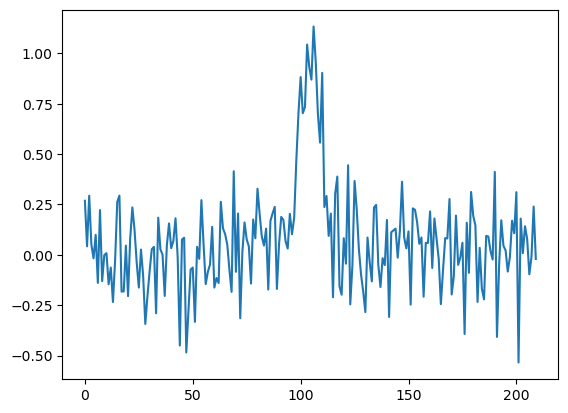

In [57]:
# torch.manual_seed(1)
exp_type = 'cth'
save_path = os.path.join('./results/',  exp_type)
os.makedirs(save_path, exist_ok=True)

### initialize LSC and PSC
LSCModel = LSC(params_LSC).to(device)
PSCModel = PSC(params_PSC).to(device)

### stimulus and ground truth position
pos_gt = torch.tensor(30., dtype=torch.float32)  # ground truth position
pos_gt = pos_gt.to(device)
phi_gt = position2phase_modules(pos_gt, params_PSC)

pos_gt_np = pos_gt.detach().cpu().clone().numpy()
phi_gt_np = phi_gt.detach().cpu().clone().numpy()

total_iterations = 5000
n_methods = 3
rate_ampl = 2.
pg_ratio = 0.0874/0.00716
phi_ampl = 5.0
activation_p = LSCModel.forward(pos_gt, noiseFlag=True,  rate_ampl=rate_ampl*pg_ratio)
activation_gs = PSCModel.forward(pos_gt, noiseFlag=True, rate_ampl=rate_ampl, phi_ampl=phi_ampl)
g_noise = np.array(PSCModel.sigma_g*rate_ampl)
p_noise = np.array(LSCModel.sigma_p*rate_ampl*pg_ratio)
phi_noise = np.array(PSCModel.sigma_phi*phi_ampl)
print('sigma_g:', g_noise)
print('sigma_phi:', phi_noise)
print('sigma_p:', p_noise)
plt.figure()
plt.plot(activation_p)
### PSC GOP decoding
# z_t = pos_gt # previous position
# phi_t = position2phase_modules(z_t, params_PSC)
# z_ts, phi_ts = PSC_GOP_decoder(PSCModel, total_iterations, z_t, phi_t, activation_gs)
# z_ts = torch.stack(z_ts).detach().cpu().numpy() # shape [total_iterations+1, 1]
# phi_ts = torch.stack(phi_ts).detach().cpu().numpy() # shape [total_iterations+1, M]
# plt.plot(z_ts)

# plt.figure()
### PSC MAP decoding
z_est_MAP, phi_est_MAP = Simplified_PSC_MAP_decoder(PSCModel, activation_gs)
z_place_MAP = LSC_MAP_decoder(LSCModel, activation_p)
print(z_est_MAP)
print(z_place_MAP)
# print(z_ts[-1])
# print(phi_ts[-1])


In [59]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # 用于显示进度条

torch.manual_seed(1)
exp_type = 'cth'
save_path = os.path.join('./results/', exp_type)
os.makedirs(save_path, exist_ok=True)

### initialize LSC and PSC
LSCModel = LSC(params_LSC).to(device)
PSCModel = PSC(params_PSC).to(device)

### stimulus and ground truth position
pos_gt = torch.tensor(30., dtype=torch.float32)  # ground truth position
pos_gt = pos_gt.to(device)
phi_gt = position2phase_modules(pos_gt, params_PSC)

pos_gt_np = pos_gt.detach().cpu().clone().numpy()
phi_gt_np = phi_gt.detach().cpu().clone().numpy()

# total_iterations = 5000
# n_methods = 3
num_simulation = 1000
num_rate = 15
rate_ampl_all = np.linspace(0, 10, num_rate)
z_decode_psc_mean = np.zeros(num_rate)
z_decode_psc_gop_mean = np.zeros(num_rate)
z_decode_lsc_mean = np.zeros(num_rate)
z_decode_psc_std = np.zeros(num_rate)
z_decode_psc_gop_std = np.zeros(num_rate)
z_decode_lsc_std = np.zeros(num_rate)
g_noise_stre = np.zeros(num_rate)
p_noise_stre = np.zeros(num_rate)

for j in tqdm(range(num_rate), desc='Rate Amplitude Loop'):
    rate_ampl = rate_ampl_all[j]
    z_decode_psc = np.zeros(num_simulation)
    z_decode_psc_gop = np.zeros(int(num_simulation/50))
    z_decode_lsc = np.zeros(num_simulation)
    sigma_g0 = np.array(PSCModel.sigma_g)[0]
    sigma_p0 = np.array(LSCModel.sigma_p)
    pg_ratio = sigma_g0 / sigma_p0
    g_noise = np.array(PSCModel.sigma_g * rate_ampl)
    p_noise = np.array(LSCModel.sigma_p * rate_ampl * pg_ratio)
    phi_noise = np.array(PSCModel.sigma_phi * phi_ampl)
    for i in tqdm(range(num_simulation), desc=f'Simulation Loop for Rate Amplitude {rate_ampl}', leave=True):

        phi_ampl = 5.0
        # activation_p = LSCModel.forward(pos_gt, noiseFlag=True, rate_ampl=rate_ampl * pg_ratio)
        # activation_gs = PSCModel.forward(pos_gt, noiseFlag=True, rate_ampl=rate_ampl, phi_ampl=phi_ampl)
        activation_p = LSCModel.forward(pos_gt, noiseFlag=True, rate_ampl=rate_ampl)
        activation_gs = PSCModel.forward(pos_gt, noiseFlag=True, rate_ampl=rate_ampl, phi_ampl=0.5)

        ### PSC MAP decoding
        z_est_MAP, phi_est_MAP = Simplified_PSC_MAP_decoder(PSCModel, activation_gs)
        z_place_MAP = LSC_MAP_decoder(LSCModel, activation_p)
        z_decode_psc[i] = z_est_MAP
        z_decode_lsc[i] = z_place_MAP
        # z_ts = torch.stack(z_ts).detach().cpu().numpy() # shape [total_iterations+1, 1]
        # phi_ts = torch.stack(phi_ts).detach().cpu().numpy() # shape [total_iterations+1, M]
        # plt.plot(z_ts)
        if i % 50 == 0:
            ### PSC GOP decoding
            z_t = pos_gt # previous position
            phi_t = position2phase_modules(z_t, params_PSC)
            z_ts, phi_ts = PSC_GOP_decoder(PSCModel, total_iterations, z_t, phi_t, activation_gs)
            z_gop = np.array(z_ts)
            z_decode_psc_gop[i//50] = z_gop[-1]

    error_psc = np.abs(z_decode_psc - 30)
    error_psc_gop = np.abs(z_decode_psc_gop - 30)
    error_lsc = np.abs(z_decode_lsc - 30)

    g_noise_stre[j] = g_noise[0]
    p_noise_stre[j] = p_noise

    z_decode_psc_mean[j] = np.mean(error_psc)
    z_decode_psc_gop_mean[j] = np.mean(error_psc_gop)
    z_decode_lsc_mean[j] = np.mean(error_lsc)

    z_decode_psc_std[j] = np.std(error_psc)
    z_decode_psc_gop_std[j] = np.std(error_psc_gop)
    z_decode_lsc_std[j] = np.std(error_lsc)

# 保存结果
np.save(os.path.join(save_path, 'z_decode_psc_mean.npy'), z_decode_psc_mean)
np.save(os.path.join(save_path, 'z_decode_lsc_mean.npy'), z_decode_lsc_mean)
np.save(os.path.join(save_path, 'z_decode_psc_gop_mean.npy'), z_decode_psc_gop_mean)
np.save(os.path.join(save_path, 'z_decode_psc_std.npy'), z_decode_psc_std)
np.save(os.path.join(save_path, 'z_decode_lsc_std.npy'), z_decode_lsc_std)
np.save(os.path.join(save_path, 'z_decode_psc_gop_std.npy'), z_decode_psc_gop_std)

# 绘制带阴影误差条的图



Simulation Loop for Rate Amplitude 0.0: 100%|██████████| 1000/1000 [00:45<00:00, 22.03it/s]
Simulation Loop for Rate Amplitude 0.7142857142857143: 100%|██████████| 1000/1000 [00:45<00:00, 22.10it/s]
Simulation Loop for Rate Amplitude 1.4285714285714286: 100%|██████████| 1000/1000 [00:43<00:00, 22.85it/s]
Simulation Loop for Rate Amplitude 2.142857142857143: 100%|██████████| 1000/1000 [00:42<00:00, 23.52it/s]
Simulation Loop for Rate Amplitude 2.857142857142857: 100%|██████████| 1000/1000 [00:41<00:00, 24.13it/s]
Simulation Loop for Rate Amplitude 3.5714285714285716: 100%|██████████| 1000/1000 [00:43<00:00, 22.80it/s]
Simulation Loop for Rate Amplitude 4.285714285714286: 100%|██████████| 1000/1000 [00:43<00:00, 22.75it/s]
Simulation Loop for Rate Amplitude 5.0: 100%|██████████| 1000/1000 [00:44<00:00, 22.58it/s]
Simulation Loop for Rate Amplitude 5.714285714285714: 100%|██████████| 1000/1000 [00:45<00:00, 21.76it/s]
Simulation Loop for Rate Amplitude 6.428571428571429: 100%|██████████| 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


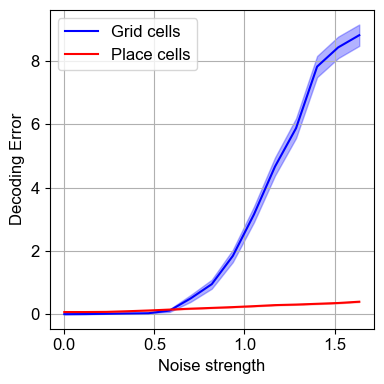

In [69]:

plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})
plt.figure(figsize=(4, 4))

plt.plot(g_noise_stre, z_decode_psc_mean, label='Grid cells', color='blue')
# plt.plot(g_noise_stre, z_decode_psc_gop_mean, label='PSC GOP', color='green')
plt.fill_between(g_noise_stre, z_decode_psc_mean - z_decode_psc_std/30, z_decode_psc_mean + z_decode_psc_std/30, color='blue', alpha=0.3)

plt.plot(p_noise_stre, z_decode_lsc_mean*10, label='Place cells', color='red')
plt.fill_between(p_noise_stre, 10*z_decode_lsc_mean - 10*z_decode_lsc_std/30, 10*z_decode_lsc_mean + 10*z_decode_lsc_std/30, color='red', alpha=0.3)

plt.xlabel('Noise strength')
plt.ylabel('Decoding Error')
# plt.title('Decoding Error vs Rate Amplitude')
plt.legend()
plt.grid(True)
# plt.savefig(os.path.join(save_path, 'decoding_error_vs_rate_amplitude.png'))
# plt.xlim(0,1)
# plt.ylim(0,4)

plt.tight_layout()
plt.savefig('figures_cth/Bayesian_integration.eps')
plt.show()

# 绘制带阴影误差条的图
# plt.figure(figsize=(4, 4))
# # rate_ampl_all = np.linspace(0, 5, num_rate)

# plt.plot(g_noise_stre, np.log(z_decode_psc_mean), label='PSC', color='blue')
# plt.plot(g_noise_stre, np.log(z_decode_lsc_mean), label='LSC', color='red')

# # plt.plot(g_noise_stre, z_decode_psc_mean, label='PSC MAP', color='blue')
# plt.plot(g_noise_stre, np.log(z_decode_psc_gop_mean), label='PSC GOP', color='green')
# # plt.fill_between(rate_ampl_all, z_decode_psc_mean - z_decode_psc_std, z_decode_psc_mean + z_decode_psc_std, color='blue', alpha=0.3)

# # plt.plot(p_noise_stre, z_decode_lsc_mean, label='LSC MAP', color='red')
# # plt.plot(p_noise_stre, z_decode_lsc_mean, label='LSC Mean', color='red')

# plt.xlabel('Noise strength')
# plt.ylabel('log Decoding Error')
# # plt.title('Decoding Error vs Rate Amplitude')
# plt.legend()
# plt.grid(True)
# plt.savefig(os.path.join(save_path, 'decoding_error_vs_rate_amplitude.png'))
# plt.show()

Simulation Loop for Rate Amplitude 10: 100%|██████████| 10000/10000 [00:47<00:00, 209.65it/s]


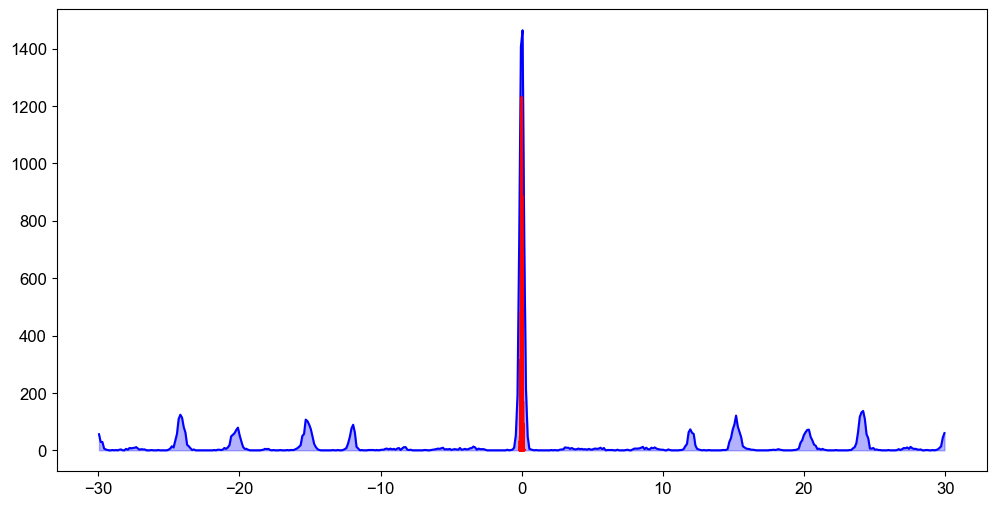

In [72]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # 用于显示进度条

torch.manual_seed(1)
exp_type = 'cth'
save_path = os.path.join('./results/', exp_type)
os.makedirs(save_path, exist_ok=True)

### initialize LSC and PSC
LSCModel = LSC(params_LSC).to(device)
PSCModel = PSC(params_PSC).to(device)

### stimulus and ground truth position
pos_gt = torch.tensor(30., dtype=torch.float32)  # ground truth position
pos_gt = pos_gt.to(device)
phi_gt = position2phase_modules(pos_gt, params_PSC)

pos_gt_np = pos_gt.detach().cpu().clone().numpy()
phi_gt_np = phi_gt.detach().cpu().clone().numpy()

# total_iterations = 5000
# n_methods = 3
num_simulation = 10000
num_rate = 15
rate_ampl = 10
z_decode_psc = np.zeros(num_simulation)
z_decode_psc_gop = np.zeros(int(num_simulation/50))
z_decode_lsc = np.zeros(num_simulation)
sigma_g0 = np.array(PSCModel.sigma_g)[0]
sigma_p0 = np.array(LSCModel.sigma_p)
pg_ratio = sigma_g0 / sigma_p0
g_noise = np.array(PSCModel.sigma_g * rate_ampl)
p_noise = np.array(LSCModel.sigma_p * rate_ampl * pg_ratio)
phi_noise = np.array(PSCModel.sigma_phi * phi_ampl)

for i in tqdm(range(num_simulation), desc=f'Simulation Loop for Rate Amplitude {rate_ampl}', leave=True):

    phi_ampl = 5.0
    activation_p = LSCModel.forward(pos_gt, noiseFlag=True, rate_ampl=rate_ampl)
    activation_gs = PSCModel.forward(pos_gt, noiseFlag=True, rate_ampl=rate_ampl, phi_ampl=0.5)

    ### PSC MAP decoding
    z_est_MAP, phi_est_MAP = Simplified_PSC_MAP_decoder(PSCModel, activation_gs)
    z_place_MAP = LSC_MAP_decoder(LSCModel, activation_p)
    z_decode_psc[i] = z_est_MAP
    z_decode_lsc[i] = z_place_MAP

error_psc = z_decode_psc - 30
error_lsc = z_decode_lsc - 30





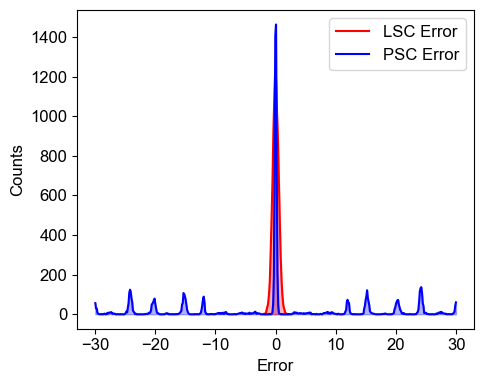

In [101]:


# Load the data (assuming 'error_psc' and 'error_lsc' are provided)
# error_psc = ...
# error_lsc = ...

# Compute the histogram for the PSC and LSC errors
counts_psc, bin_edges_psc = np.histogram(error_psc, bins=500)
counts_lsc, bin_edges_lsc = np.histogram(error_lsc*10, bins=500)

# Calculate the bin centers
bin_centers_psc = (bin_edges_psc[:-1] + bin_edges_psc[1:]) / 2
bin_centers_lsc = (bin_edges_lsc[:-1] + bin_edges_lsc[1:]) / 2

# Remove zero points
nonzero_indices_lsc = counts_lsc > 0
bin_centers_lsc = bin_centers_lsc[nonzero_indices_lsc]
counts_lsc = counts_lsc[nonzero_indices_lsc]

# Plot the histogram with non-zero points only
plt.figure(figsize=(5, 4))
plt.plot(bin_centers_lsc, counts_lsc, label='LSC Error', color='red')
plt.plot(bin_centers_psc, counts_psc, label='PSC Error', color='blue')

plt.fill_between(bin_centers_psc, counts_psc, color='blue', alpha=0.3)
plt.fill_between(bin_centers_lsc, counts_lsc, color='red', alpha=0.3)

plt.xlabel('Error')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.savefig('figures_cth/Non_local_error.pdf')
plt.show()


In [ ]:


# # save the results
# z_est_arrays[pi_index,n_index,0] = z_est_GOP
# z_est_arrays[pi_index,n_index,1] = z_est_MAP
# z_est_arrays[pi_index,n_index,2] = z_est_LSC
# print('z_est:', z_est_GOP, z_est_MAP, z_est_LSC)

# for module in range(params_PSC['M']):
#     phi_est_arrays[pi_index,n_index,0,module] = phi_est_GOP[module]
#     phi_est_arrays[pi_index,n_index,1,module] = phi_est_MAP[module]
#     phi_est_arrays[pi_index,n_index,2,module] = None

# # save the results
# np.save(os.path.join(save_path, 'z_est_arrays.npy'), z_est_arrays)
# np.save(os.path.join(save_path, 'phi_est_arrays.npy'), phi_est_arrays)

In [ ]:
# torch.manual_seed(1)
# exp_type = 'cth'
# save_path = os.path.join('./results/',  exp_type)
# os.makedirs(save_path, exist_ok=True)

# ### initialize LSC and PSC
# LSCModel = LSC(params_LSC).to(device)
# PSCModel = PSC(params_PSC).to(device)

# ### stimulus and ground truth position
# pos_gt = torch.tensor(30., dtype=torch.float32)  # ground truth position
# pos_gt = pos_gt.to(device)
# phi_gt = position2phase_modules(pos_gt, params_PSC)

# pos_gt_np = pos_gt.detach().cpu().clone().numpy()
# phi_gt_np = phi_gt.detach().cpu().clone().numpy()

# rate_ampls = np.array([0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6., 7., 8., 9., 10.])
# num_simulation = 10
# total_iterations = 5000
# n_rate_ampls = len(rate_ampls)
# n_methods = 3
# z_est_arrays = np.zeros([n_rate_ampls, num_simulation, n_methods])
# phi_est_arrays = np.zeros([n_rate_ampls, num_simulation, n_methods, params_PSC['M']])

# for pi_index, rate_ampl in enumerate(rate_ampls):
#     rate_ampl = float(rate_ampl)
#     for n_index in range(num_simulation):
#         print('Simulation trial:', n_index)
#         ### generate observation
#         activation_p = LSCModel.forward(pos_gt,noiseFlag=True,  rate_ampl=rate_ampl)
#         activation_gs = PSCModel.forward(pos_gt, noiseFlag=True, rate_ampl=rate_ampl)

#         ### PSC GOP decoding
#         # z_t = pos_gt - params_prob["v"] * params_prob["dt"] # previous position
#         z_t = pos_gt # previous position
#         phi_t = position2phase_modules(z_t, params_PSC)
#         z_ts, phi_ts = PSC_GOP_decoder(PSCModel, total_iterations, z_t, phi_t, activation_gs)
#         z_ts = torch.stack(z_ts).detach().cpu().numpy() # shape [total_iterations+1, 1]
#         phi_ts = torch.stack(phi_ts).detach().cpu().numpy() # shape [total_iterations+1, M]
        
#         z_est_GOP = z_ts[-1]
#         phi_est_GOP = phi_ts[-1]
#         # clear z_ts, phi_ts
#         z_ts, phi_ts = [], []

#         ### PSC MAP decoding
#         z_est_MAP, phi_est_MAP = PSC_MAP_decoder(LSCModel, PSCModel, activation_gs)

#         ### LSC MAP decoding
#         z_est_LSC = LSC_MAP_decoder(LSCModel, activation_p)

#         # save the results
#         z_est_arrays[pi_index,n_index,0] = z_est_GOP
#         z_est_arrays[pi_index,n_index,1] = z_est_MAP
#         z_est_arrays[pi_index,n_index,2] = z_est_LSC
#         print('z_est:', z_est_GOP, z_est_MAP, z_est_LSC)

#         for module in range(params_PSC['M']):
#             phi_est_arrays[pi_index,n_index,0,module] = phi_est_GOP[module]
#             phi_est_arrays[pi_index,n_index,1,module] = phi_est_MAP[module]
#             phi_est_arrays[pi_index,n_index,2,module] = None

# # save the results
# np.save(os.path.join(save_path, 'z_est_arrays.npy'), z_est_arrays)
# np.save(os.path.join(save_path, 'phi_est_arrays.npy'), phi_est_arrays)